In [1]:
from skimage import io, color
import matplotlib.pyplot as plt
from skimage import exposure
import pylab
import cv2 as cv
# from tqdm import tqdm
import matplotlib.image as mpimg
import numpy as np
import scipy as scp
from PIL import Image, ImageDraw
from scipy.signal import convolve2d
import time
from pyunlocbox import functions
from pyunlocbox import solvers
import pyunlocbox
from skimage import img_as_float
import matplotlib
from skimage.io import imread
from skimage.measure import compare_psnr
matplotlib.use('PDF')
plt.style.use('ggplot') 
%matplotlib inline

# Functions

In [2]:
def prox_alg(f, f_grad, g_prox, x0, num_iter, beta=0.5, fix_lam=None, accel=False):
    conv = [x0]
    x = x0.copy()
    if accel:
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
    if fix_lam is None:
        lam = 1.
    for i in range(num_iter):
        if accel and i > 0:
            x = x + (t_prev - 1) / t_next * (x - conv[-2])
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
        if fix_lam is None:
            while True:
                z = g_prox(x - lam * f_grad(x), lam)
                if f(z) <= f(x) + f_grad(x).dot(z - x) + np.linalg.norm(z - x)**2 / (2 * lam):
                    break
                else:
                    lam = lam * beta
        else:
            z = g_prox(x - fix_lam * f_grad(x), fix_lam)
        x = z.copy()
        conv.append(x)
    return x, conv

In [3]:
gamma = 1
f = lambda x: np.linalg.norm(A.dot(x) - y)**2 / 2
f_grad = lambda x: A.T.dot(A.dot(x) - y)

def g_prox(h, lam):
    return np.sign(h) * np.maximum(np.abs(h) - lam * gamma, 0) 

In [4]:
def FISTA(y, A, norma, tau = 100.):
    if norma == 1:
        f1 = functions.norm_l1(maxit=50, dim=2)
    else:
        f1 = functions.norm_tv(maxit=50, dim=2)
        
    f2 = functions.norm_l2(y =y, A = A, lambda_=tau)
    solver = solvers.forward_backward(step=0.5/tau)
    x0 = np.array(y)  # Make a copy to preserve im_masked.
    ret = solvers.solve([f1, f2], x0, solver, maxit=100)#, verbosity='ALL')
    return ret

def IST(y, A, norma, tau = 100.):
    if norma == 1:
        f1 = functions.norm_l1(maxit=50, dim=2)
    else:
        f1 = functions.norm_tv(maxit=50, dim=2)
        
    f2 = functions.norm_l2(y =y, A = A, lambda_=tau)
 
    x0_IST = np.array(y)  
    solver_IST = solvers.forward_backward(step=0.5/tau, accel = pyunlocbox.acceleration.dummy())
    
    IST = solvers.solve([f1, f2], x0_IST, solver_IST, maxit=100)#, verbosity='ALL')
    return IST

In [5]:
def tv_norm(x):
    h = np.array([0, 1, -1]).reshape(1,-1)
    v = h.T
    h = convolve2d(x, h, boundary='wrap', mode='same')
    v = convolve2d(x, v, boundary='wrap', mode='same')
    return np.sum(np.sqrt(h**2 + v**2))

def soft_1(a, T):
    return np.sign(a)*np.max([abs(a)-T, 0])

soft = np.vectorize(soft_1)

def divergence(p1, p2):
    u = np.empty(p1.shape)
    v = np.empty(p2.shape)
    
    z = p1[1:-1,:] - p1[:-2,:]
    u[0,:] = p1[0,:]
    u[1:-1,:] = z
    u[-1,:] = -p1[-1,:]

    z = p2[:,1:-1] - p2[:,:-2]
    v[:,0] = p2[:,0]
    v[:,1:-1] = z
    v[:,-1] = - p2[:,-1]

    return v + u

def gradient(u):
    z = u[1:, :] - u[:-1,:]
    dux = np.append(z, np.zeros(z.shape[1]).reshape(1,-1), axis = 0)

    z = u[:,1:] - u[:,:-1]
    duy = np.append(z, np.zeros(z.shape[0]).reshape(-1,1), axis = 1)
    
    return dux, duy

def chambolle(x, px, py, threshold=1, max_iter=20, tol=1e-3):
    cont = 1
    k = 0
    tau = 0.249
    
    while cont: 
        k += 1
        divp = divergence(px,py) 
        u = divp - x / threshold
        upx, upy = gradient(u)
        tmp = np.sqrt(upx**2 + upy**2)
        err = np.sum((- upx + tmp * px)**2 + (- upy + tmp * py)**2)**0.5
        px = (px + tau * upx) / (1 + tau * tmp)
        py = (py + tau * upy) / (1 + tau * tmp)
        cont = ((k < max_iter) & (err > tol))

    f = x - threshold * divergence(px, py)
    return f, px, py

# Synthetic Data

In [6]:
m, n  = 150, 100
A = np.random.randn(m,n)
x1 = np.zeros(n)

idx = np.random.choice(n, n//20)
x1[idx] = 1

# noisy measuremnts
y = A@x1 + 0.2 * np.random.randn(m)


x0 = np.random.randn(A.shape[1])
num_iter = 150

x, conv = prox_alg(f, f_grad, g_prox, x0, num_iter, fix_lam=None)
print("Number nonzeros in x* = {}".format(np.sum(x != 0)))
print("f* = {}".format(f(x) + gamma * np.linalg.norm(x, 1)))

x_acc, conv_acc = prox_alg(f, f_grad, g_prox, x0, num_iter, fix_lam=None, accel=True)
print("Number nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("f* = {}".format(f(x_acc) + gamma * np.linalg.norm(x_acc, 1)))


Number nonzeros in x* = 60
f* = 7.30550841458432
Number nonzeros in x* = 60
f* = 7.3053992440156374


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


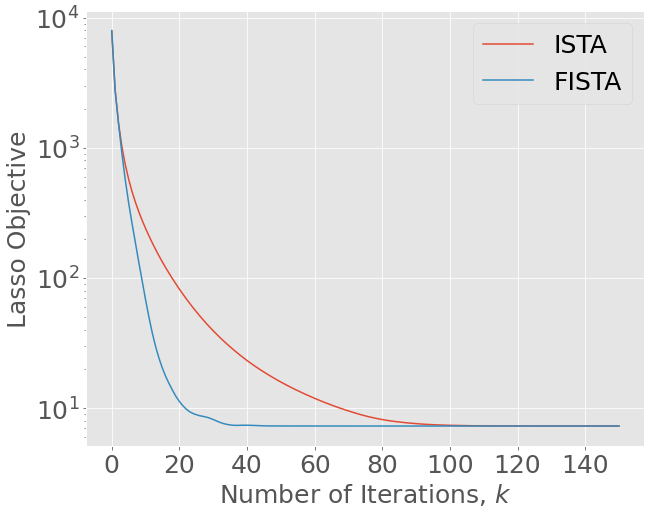

In [7]:
plt.figure(figsize=(10, 8))
fontsize=25
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv], label="ISTA")
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv_acc], label="FISTA")
plt.legend(fontsize=fontsize)
plt.xlabel(r"Number of Iterations, $k$", fontsize=fontsize)
plt.ylabel("Lasso Objective", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.yscale("log")
plt.savefig('convergence.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


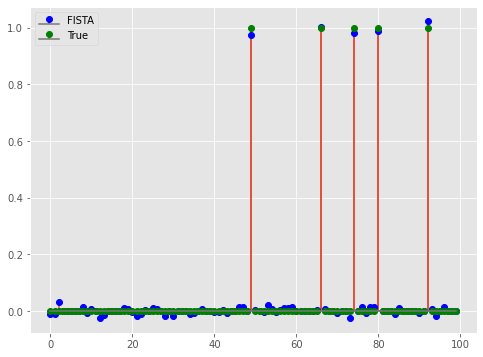

In [8]:
plt.figure(figsize=(8, 6))
plt.stem(x_acc,markerfmt='bo',label="FISTA")
plt.stem(x1, markerfmt='go', label="True")
plt.legend(fontsize=10)
plt.savefig('fista.eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


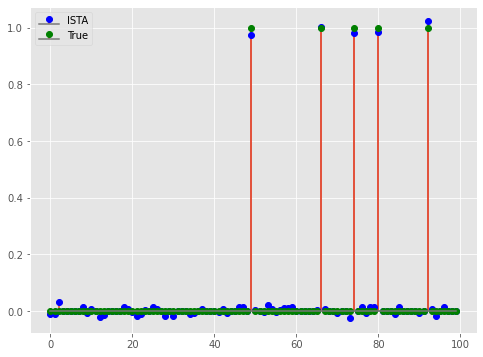

In [9]:
plt.figure(figsize=(8, 6))
plt.stem(x,markerfmt='bo',label="ISTA")
plt.stem(x1, markerfmt='go',label="True")
plt.legend(fontsize=10)
plt.savefig('ista.eps')

plt.show()

# Image

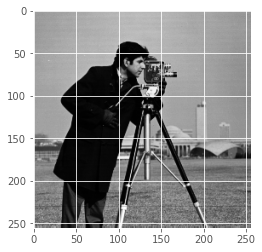

In [10]:
im_original = mpimg.imread('cameraman.tif')
plt.imshow(im_original, cmap='gray')
# normalize the image.
im_original = 1.*(im_original - np.min(im_original))/np.max(im_original)

# Part 1: Image denoising

In [11]:
# Image deblurring, with total variation. 9*9 uniform blur, and Gaussian noise (SNR = 40 dB).

# original image
x = np.array(im_original) 
M, N = x.shape

# function handle for uniform blur operator (acts on the image coefficients)
h = np.ones(9)
lh = len(h)
h = h / np.sum(h);
h = np.append(h, np.zeros(len(x)-len(h)))
h = np.roll(h, -(lh - 1) // 2)
h = h.reshape(-1,1)
h = h.dot(h.T)

H_FFT = np.fft.fft2(h)
HC_FFT = np.conj(H_FFT)

# observation
A = lambda x: np.real(np.fft.ifft2(np.multiply(H_FFT,np.fft.fft2(x))))
AT = lambda x: np.real(np.fft.ifft2(np.multiply(HC_FFT,np.fft.fft2(x))))

# algorithm parameters
tau_1 = 2.5e-2 # reg parameter
mu_1 = tau_1/10.

tau_tv = 0.001 # reg parameter
mu_tv = tau_tv/10.

num_iters = 500
tol = 1e-5

def invLS_mu(mu):
    
    filter_FFT = 1 / (np.abs(H_FFT)**2 + mu)
    invLS = lambda x: np.real(np.fft.ifft2(filter_FFT * np.fft.fft2(x)))
    
    return invLS

SNR = 40
sigma = np.linalg.norm(A(x) - np.mean(A(x)), 'fro') / np.sqrt(N * M * 10**(SNR / 10))
y = A(x) + sigma * np.random.randn(M,N)

In [12]:
ret_1norm = FISTA(y, A, norma = 1)

Solution found after 11 iterations:
    objective function f(sol) = 2.894681e+04
    stopping criterion: RTOL


In [13]:
ret_tv_norm = FISTA(y, A, norma = 2)

Solution found after 15 iterations:
    objective function f(sol) = 1.322565e+03
    stopping criterion: RTOL


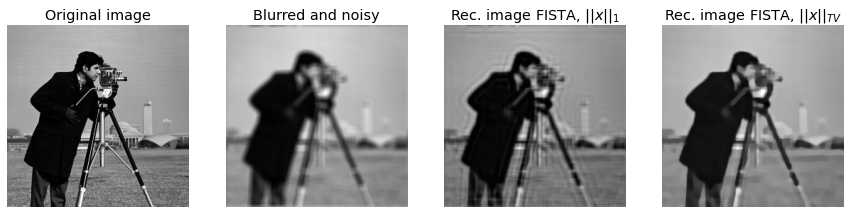

In [14]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original image')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image FISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image FISTA, $\|\| x \|\|_{TV}$')


plt.savefig('FISTA_debluring'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

In [15]:
ret_1norm_IST = IST(y, A, norma = 1)

Solution found after 11 iterations:
    objective function f(sol) = 2.915212e+04
    stopping criterion: RTOL


In [16]:
ret_tv_norm_IST = IST(y, A, norma = 2)

Solution found after 95 iterations:
    objective function f(sol) = 1.295602e+03
    stopping criterion: RTOL


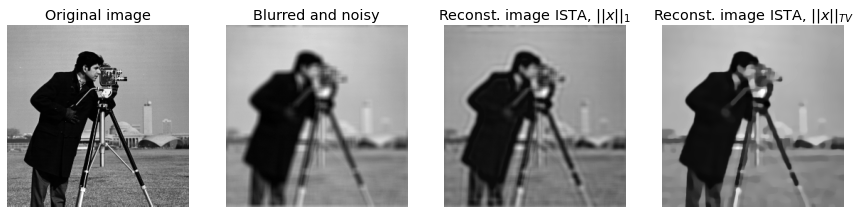

In [17]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original image')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm_IST['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Reconst. image ISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm_IST['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Reconst. image ISTA, $\|\| x \|\|_{TV}$')


plt.savefig('FISTA_IST_debluring'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

# Part 2: mask

In [18]:
x = np.array(im_original)

np.random.seed(14)  # Reproducible results.
mask = np.random.uniform(size=x.shape)
mask = mask > 0.85

g_mask = lambda x: mask * x
im_masked = g_mask(x)

g_T_mask = lambda x: mask * x

tau = 0.111 # reg parameter
mu = tau/10.

invLS = lambda x: 1. / mu * (x - 1. / (1. + mu) * g_T_mask(g_mask(x)))

In [19]:
ret_tvnorm_mask_FISTA = FISTA(im_masked, g_mask, norma = 2)

Solution found after 51 iterations:
    objective function f(sol) = 1.919684e+03
    stopping criterion: RTOL


In [20]:
ret_tvnorm_mask_ISTA = IST(im_masked, g_mask, norma = 2)

Solution found after 100 iterations:
    objective function f(sol) = 6.755088e+03
    stopping criterion: MAXIT


<ipython-input-21-1f53c6d04f58>:8: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tvnorm_mask_FISTA['sol']), 3)))
<ipython-input-21-1f53c6d04f58>:11: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tvnorm_mask_ISTA['sol']), 3)))


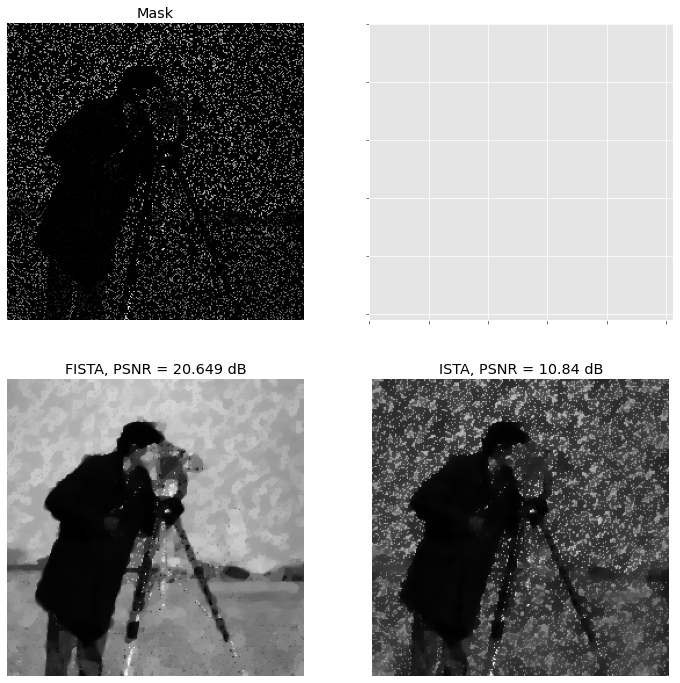

In [21]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(im_masked, cmap='gray')
axes[0][0].set_title('Mask')
axes[0][0].axis('off')

axes[1][0].imshow(ret_tvnorm_mask_FISTA['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tvnorm_mask_FISTA['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_tvnorm_mask_ISTA['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tvnorm_mask_ISTA['sol']), 3)))
axes[1][1].axis('off')

plt.savefig('mask'+ '.pdf', format = 'pdf', bbox_inches = 'tight')